In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Set the path to your dataset folder in Google Drive
dataset_path = "/content/drive/MyDrive/Training"

In [3]:

# Set the target size for image resizing
target_size = (224, 224)

# Initialize empty lists to store images and labels
images = []
labels = []

# Loop through each tumor type folder
for tumor_type in os.listdir(dataset_path):
    tumor_type_path = os.path.join(dataset_path, tumor_type)

    # Loop through each image in the tumor type folder
    for image_file in os.listdir(tumor_type_path):
        image_path = os.path.join(tumor_type_path, image_file)

        # Read the image using OpenCV
        img = cv2.imread(image_path)

        # Apply unsharp mask filter
        blurred = cv2.GaussianBlur(img, (0, 0), 3)
        img = cv2.addWeighted(img, 1.5, blurred, -0.5, 0)

        # Resize the image to the target size
        img = cv2.resize(img, target_size)

        # Append the original image and label to the lists
        images.append(img)
        labels.append(tumor_type)

        # Data Augmentation
        datagen = ImageDataGenerator(
            horizontal_flip=True,
            rotation_range=20,
            zoom_range=0.2,
            height_shift_range=0.2,
            width_shift_range=0.2,
            shear_range=0.2,
            fill_mode='nearest'
        )

        # Generate augmented images and append them to the lists
        augmented_images = [datagen.random_transform(img) for _ in range(1)]  # Generate 2 augmented images per original
        images.extend(augmented_images)
        labels.extend([tumor_type] * len(augmented_images))

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:


# Convert lists to NumPy arrays for model training
X = np.array(images)
y = np.array(labels)



In [6]:
# Print the shape of X and y to check
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (9344, 224, 224, 3)
Shape of y: (9344,)


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split

In [8]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Convert labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

In [10]:
# Define a simple CNN model for feature extraction
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())

In [11]:
# Add Dense layers for classification (adjust the number of units based on your classes)
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))  # Assuming there are 6 classes

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
# Train the model with validation data
history = model.fit(X_train, y_train_encoded, epochs=32, batch_size=16, validation_data=(X_val, y_val_encoded))

Epoch 1/32
468/468 [==============================] - 17s 29ms/step - loss: 5.2408 - accuracy: 0.5968 - val_loss: 0.8103 - val_accuracy: 0.6758
Epoch 2/32
468/468 [==============================] - 12s 26ms/step - loss: 0.6471 - accuracy: 0.7477 - val_loss: 0.7366 - val_accuracy: 0.7132
Epoch 3/32
468/468 [==============================] - 12s 26ms/step - loss: 0.4527 - accuracy: 0.8227 - val_loss: 0.8008 - val_accuracy: 0.7063
Epoch 4/32
468/468 [==============================] - 12s 26ms/step - loss: 0.2652 - accuracy: 0.9046 - val_loss: 0.9964 - val_accuracy: 0.7389
Epoch 5/32
468/468 [==============================] - 12s 26ms/step - loss: 0.1967 - accuracy: 0.9350 - val_loss: 1.0721 - val_accuracy: 0.7362
Epoch 6/32
468/468 [==============================] - 13s 27ms/step - loss: 0.1333 - accuracy: 0.9557 - val_loss: 1.2370 - val_accuracy: 0.7186
Epoch 7/32
468/468 [==============================] - 13s 27ms/step - loss: 0.0982 - accuracy: 0.9680 - val_loss: 1.1987 - val_accuracy:

In [13]:
import matplotlib.pyplot as plt

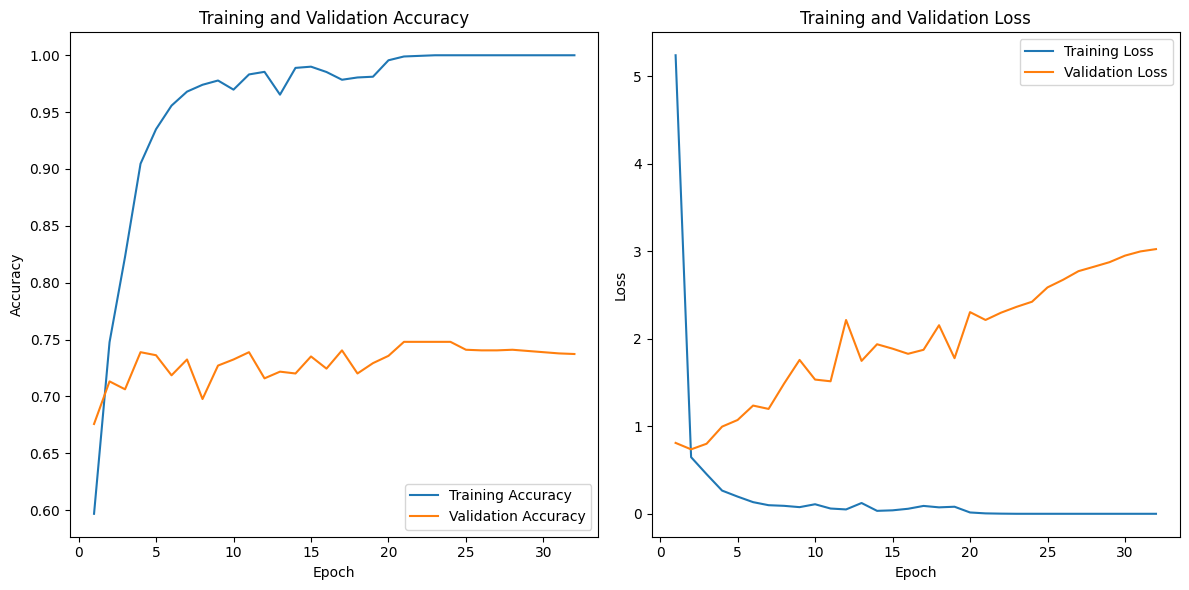

In [14]:
# Plotting accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
epochs = range(1, len(history.history['accuracy']) + 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [16]:
# Extract features using the CNN model
X_train_features = model.predict(X_train)
X_val_features = model.predict(X_val)

59/59 [==============================] - 1s 11ms/step


In [17]:
# Reshape data for Random Forest
X_train_flatten = X_train_features.reshape(X_train_features.shape[0], -1)
X_val_flatten = X_val_features.reshape(X_val_features.shape[0], -1)

In [18]:
# Initialize Random Forest classifier
random_forest_classifier = RandomForestClassifier(n_estimators=50, random_state=42)

# Train Random Forest classifier
random_forest_classifier.fit(X_train_flatten, y_train_encoded)

# Make predictions on validation set
random_forest_predictions = random_forest_classifier.predict(X_val_flatten)

# Evaluate performance
random_forest_accuracy = metrics.accuracy_score(y_val_encoded, random_forest_predictions)
random_forest_precision = metrics.precision_score(y_val_encoded, random_forest_predictions, average='weighted')
random_forest_recall = metrics.recall_score(y_val_encoded, random_forest_predictions, average='weighted')
random_forest_f1 = metrics.f1_score(y_val_encoded, random_forest_predictions, average='weighted')

# Print results
print("Random Forest (on CNN features): Accuracy = {:.4f}, Precision = {:.4f}, Recall = {:.4f}, F1 Score = {:.4f}".format(random_forest_accuracy, random_forest_precision, random_forest_recall, random_forest_f1))

Random Forest (on CNN features): Accuracy = 0.7368, Precision = 0.7395, Recall = 0.7368, F1 Score = 0.7378


In [19]:
from sklearn.neighbors import KNeighborsClassifier
# Initialize k-NN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors as needed

# Train k-NN classifier
knn_classifier.fit(X_train_flatten, y_train_encoded)

# Make predictions on the validation set
knn_predictions = knn_classifier.predict(X_val_flatten)

# Evaluate performance
knn_accuracy = metrics.accuracy_score(y_val_encoded, knn_predictions)
knn_precision = metrics.precision_score(y_val_encoded, knn_predictions, average='weighted')
knn_recall = metrics.recall_score(y_val_encoded, knn_predictions, average='weighted')
knn_f1 = metrics.f1_score(y_val_encoded, knn_predictions, average='weighted')

# Print results for k-NN
print("k-Nearest Neighbors (on CNN features): Accuracy = {:.4f}, Precision = {:.4f}, Recall = {:.4f}, F1 Score = {:.4f}".format(knn_accuracy, knn_precision, knn_recall, knn_f1))


k-Nearest Neighbors (on CNN features): Accuracy = 0.7373, Precision = 0.7403, Recall = 0.7373, F1 Score = 0.7384


In [20]:
from sklearn.ensemble import AdaBoostClassifier
# Initialize AdaBoost classifier with a decision tree base estimator
adaboost_classifier = AdaBoostClassifier(n_estimators=50, random_state=42)

# Train AdaBoost classifier
adaboost_classifier.fit(X_train_flatten, y_train_encoded)

# Make predictions on the validation set
adaboost_predictions = adaboost_classifier.predict(X_val_flatten)

# Evaluate performance
adaboost_accuracy = metrics.accuracy_score(y_val_encoded, adaboost_predictions)
adaboost_precision = metrics.precision_score(y_val_encoded, adaboost_predictions, average='weighted')
adaboost_recall = metrics.recall_score(y_val_encoded, adaboost_predictions, average='weighted')
adaboost_f1 = metrics.f1_score(y_val_encoded, adaboost_predictions, average='weighted')

# Print results for AdaBoost
print("AdaBoost (on CNN features): Accuracy = {:.4f}, Precision = {:.4f}, Recall = {:.4f}, F1 Score = {:.4f}".format(adaboost_accuracy, adaboost_precision, adaboost_recall, adaboost_f1))


AdaBoost (on CNN features): Accuracy = 0.7368, Precision = 0.7395, Recall = 0.7368, F1 Score = 0.7378
